# Krasner Quotient Hyperfield Construction over Prime Fields

This Python program constructs and analyzes the quotient hyperfield obtained from the finite field $\mathbb{F}_p$ modulo a multiplicative subgroup of order $d$, where:

- $p$ is a prime number,
- $d$ is a divisor of $p-1$.

The quotient hyperfield is formed by taking the multiplicative quotient $\mathbb{F}_p^\times / G$ (where $G$ is the subgroup of order $d$) and adjoining zero. The program computes and outputs:

- The **additive hyperoperation table** of this quotient hyperfield,
- The **characteristic** of the quotient hyperfield (smallest $n$ such that $0 \in 1 \boxplus \cdots \boxplus 1$, $n$ times),
- The **c-characteristic** (smallest $n$ such that $1 \in 1 \boxplus \cdots \boxplus 1$, $n+1$ times).

## Features

- Works purely with integer modular arithmetic—no external libraries required.
- Finds a primitive root modulo $p$ to construct the multiplicative subgroup.
- Computes coset representatives of $\mathbb{F}_p^\times / G$.
- Prints a readable table displaying the additive hyperoperation.
- Computes and displays characteristic and c-characteristic.

## Requirements

- Python 3.x standard environment.
- No special external packages needed.

## How to Run

1. Save the code in a `.py` file or run interactively in Python.
2. Run the program.
3. When prompted, enter a prime number $p$.
4. Enter a divisor $d$ of $p-1$.
5. View the printed hyperaddition table and characteristics.

## Code Structure Overview

- `is_prime(n)` — Basic primality test.
- `find_primitive_root(p)` — Finds generator of $\mathbb{F}_p^\times$.
- `construct_subgroup(p, d, g)` — Builds subgroup $G$.
- `coset_representatives(p, G, g)` — Finds coset reps of quotient.
- `hyperaddition(...)` — Computes set-valued sum of cosets.
- Table building, printing, and characteristic computations follow.

## License

This code is provided as-is for educational and research purposes. If published elsewhere, the creator should be cited.

***

Feel free to ask if you want a markdown file or additional usage instructions!



In [ ]:
import pandas as pd

def is_prime(n):
    if n < 2:
        return False
    if n == 2:
        return True
    if n % 2 == 0:
        return False
    r = int(n**0.5)
    for i in range(3, r+1, 2):
        if n % i == 0:
            return False
    return True

def find_primitive_root(p):
    # Finds a primitive root modulo p (generator of the multiplicative group)
    # Works only for prime p
    if p == 2:
        return 1
    phi = p - 1
    factors = prime_factors(phi)
    for g in range(2, p):
        if all(pow(g, phi // f, p) != 1 for f in factors):
            return g
    raise ValueError("No primitive root found (should not happen for prime p)")

def prime_factors(n):
    # Returns a list of prime factors of n (without multiplicity)
    factors = []
    d = 2
    while d * d <= n:
        if n % d == 0:
            factors.append(d)
            while n % d == 0:
                n //= d
        d += 1 if d == 2 else 2
    if n > 1:
        factors.append(n)
    return factors

def construct_subgroup(p, d, g):
    # Constructs the subgroup G of order d generated by g^{(p-1)/d} mod p
    step = (p - 1) // d
    h = pow(g, step, p)
    subgroup = set(pow(h, i, p) for i in range(d))
    return subgroup

def coset_representatives(p, G, g):
    # Determine coset representatives for (Z/pZ)^*/G
    seen = set()
    reps = []
    for i in range(1, p):
        if i in seen:
            continue
        coset = {(i * x) % p for x in G}
        if not any(x in seen for x in coset):
            reps.append(i)
            seen |= coset
    return reps

def element_to_coset_idx(x, G, reps, p):
    if x == 0:
        return -1
    for idx, r in enumerate(reps):
        if any((r * g) % p == x for g in G):
            return idx
    raise ValueError(f"Element {x} not found in any coset")

def hyperaddition(p, G, reps, i, j):
    # Hyperaddition of cosets reps[i], reps[j]
    A = {(reps[i] * g) % p for g in G}
    B = {(reps[j] * g) % p for g in G}
    zero = 0
    result = set()
    for a in A:
        for b in B:
            s = (a + b) % p
            if s == zero:
                result.add(-1)
            else:
                result.add(element_to_coset_idx(s, G, reps, p))
    return result

def build_addition_table(p, G, reps):
    # Build addition table including zero element (-1)
    m = len(reps)
    # Use representatives in the table directly
    table = [[set() for _ in range(m + 1)] for _ in range(m + 1)]

    # Row/column headers based on representatives (including 0)
    headers = [0] + reps

    # Map coset index to representative
    idx_to_rep = {i: rep for i, rep in enumerate(reps)}
    idx_to_rep[-1] = 0

    for i in range(m + 1):
        for j in range(m + 1):
            if i == 0 and j == 0:
                table[i][j] = {0}
            elif i == 0:
                table[i][j] = {idx_to_rep[j-1]}
            elif j == 0:
                table[i][j] = {idx_to_rep[i-1]}
            else:
                result_indices = hyperaddition(p, G, reps, i-1, j-1)
                table[i][j] = {idx_to_rep[idx] for idx in result_indices}

    # Convert to pandas DataFrame for better visualization
    df_table = pd.DataFrame(table, index=[f"[{h}]" for h in headers], columns=[f"[{h}]" for h in headers])

    # Format the cells for readability
    def format_cell(cell_set):
        return "{" + ",".join([f"[{e}]" for e in sorted(cell_set)]) + "}"

    df_table = df_table.map(format_cell)

    return df_table

def format_cell_old(cell):
    return "{" + ",".join("0" if e == -1 else f"C{e}" for e in sorted(cell)) + "}"

def print_table_old(table):
    n = len(table) - 1
    headers = ["+"] + ["0"] + [f"C{i}" for i in range(n)]
    print('\t'.join(headers))
    for r in range(n + 1):
        row_label = "0" if r == 0 else f"C{r-1}"
        row_cells = [format_cell_old(table[r][c]) for c in range(n + 1)]
        print('\t'.join([row_label] + row_cells))

def hyper_sum_of_ones(p, G, reps, n_terms):
    # Compute 1⊞1⊞...⊞1 (n_terms)
    idx_1 = element_to_coset_idx(1, G, reps, p)
    # Need to build the table with original indices for calculation
    m = len(reps)
    table = [[set() for _ in range(m + 1)] for _ in range(m + 1)]
    for i in range(m + 1):
        table[0][i] = {i - 1} if i > 0 else {-1}
        table[i][0] = {i - 1} if i > 0 else {-1}
    for i in range(m):
        for j in range(m):
            table[i + 1][j + 1] = hyperaddition(p, G, reps, i, j)

    S = {idx_1}
    for _ in range(n_terms - 1):
        T = set()
        for a in S:
            row = a + 1 if a >= 0 else 0
            col = idx_1 + 1
            T |= table[row][col]
        S = T
    return S

def characteristic(p, G, reps, max_terms=2000):
    for n in range(1, max_terms + 1):
        if -1 in hyper_sum_of_ones(p, G, reps, n):
            return n
    return 0

def c_characteristic(p, G, reps, max_terms=2000):
    idx_1 = element_to_coset_idx(1, G, reps, p)
    for n in range(1, max_terms + 1):
        if idx_1 in hyper_sum_of_ones(p, G, reps, n + 1):
            return n
    return 0

def main():
    while True:
        try:
            p = int(input("Enter a prime number p: "))
            if not is_prime(p):
                print(f"{p} is not prime. Try again.")
                continue
            d = int(input(f"Enter divisor d of {p-1}: "))
            if d <= 0 or (p - 1) % d != 0:
                print(f"d must be a positive divisor of {p-1}. Try again.")
                continue
            break
        except ValueError:
            print("Invalid input, enter integer values.")

    g = find_primitive_root(p)
    print(f"Primitive root modulo {p} found: {g}")
    G = construct_subgroup(p, d, g)
    reps = coset_representatives(p, G, g)

    print(f"Coset representatives count: {len(reps)} (total quotient hyperfield order {len(reps)+1})")

    table_df = build_addition_table(p, G, reps)
    print("Additive hyperoperation table (+):")
    display(table_df)

    char = characteristic(p, G, reps)
    cchar = c_characteristic(p, G, reps)
    print(f"Characteristic: {char}")
    print(f"C-characteristic: {cchar}")

if __name__ == "__main__":
    main()

Enter a prime number p: 17
Enter divisor d of 16: 8
Primitive root modulo 17 found: 3
Coset representatives count: 2 (total quotient hyperfield order 3)
Additive hyperoperation table (+):


,[0],[1],[3]
[0],{[0]},{[1]},{[3]}
[1],{[1]},"{[0],[1],[3]}","{[1],[3]}"
[3],{[3]},"{[1],[3]}","{[0],[1],[3]}"


Characteristic: 2
C-characteristic: 1


# Generating pairs $(p,d)$ for a given order $n$

The next little program assists in using the previous one: given an integer $n$ as input together with an integer bound $max_p$, the program generates pairs $(p,d)$ where $p$ is a prime $\leq max_p$ and $$n=\frac{p-1}{d} + 1$$.

Thus, one can use the outputs of this program to generate hyperfields of a given order $n$ with the previous program.

In [ ]:
def find_prime_divisor_pairs(n, max_p):
    from sympy import primerange

    result = []
    # Iterate over primes less than or equal to max_p
    for p in primerange(2, max_p + 1):
        val = p - 1
        # Check if (p-1) is divisible by (n-1)
        if n == 1:
            # n = 1 case does not produce valid primes under the condition
            continue
        if (val % (n - 1)) == 0:
            d = val // (n - 1)
            # Verify n = (p-1)/d + 1
            if (val // d) + 1 == n:
                result.append((p, d))
    return result

# Example usage:
if __name__ == "__main__":
    while True:
        try:
            n = int(input("Enter the desired hyperfield order (n): "))
            if n <= 0:
                print("n must be a positive integer. Try again.")
                continue
            max_p = int(input("Enter the maximum prime to consider (max_p): "))
            if max_p <= 1:
                print("max_p must be greater than 1. Try again.")
                continue
            break
        except ValueError:
            print("Invalid input. Please enter integer values.")


    pairs = find_prime_divisor_pairs(n, max_p)
    print(f"Pairs (p, d) for hyperfield order n={n} with p <= {max_p}:")
    print(pairs)

Enter the desired hyperfield order (n): 3
Enter the maximum prime to consider (max_p): 100
Pairs (p, d) for hyperfield order n=3 with p <= 100:
[(3, 1), (5, 2), (7, 3), (11, 5), (13, 6), (17, 8), (19, 9), (23, 11), (29, 14), (31, 15), (37, 18), (41, 20), (43, 21), (47, 23), (53, 26), (59, 29), (61, 30), (67, 33), (71, 35), (73, 36), (79, 39), (83, 41), (89, 44), (97, 48)]


# Isomorphism check
The next program checks whether two hyperfields generated by pairs $(p,d)$ as above are isomorphic or not.

In [ ]:
from itertools import permutations
import pandas as pd
# Reuse functions from the first cell
# from __main__ import is_prime, find_primitive_root, construct_subgroup, coset_representatives, build_addition_table, hyperaddition, element_to_coset_idx

def check_isomorphism_via_add_table(p1, d1, p2, d2):
    # Check divisor conditions and primality
    if not is_prime(p1) or not is_prime(p2):
        return "Error: p1 and p2 must be prime numbers."
    if d1 <= 0 or (p1 - 1) % d1 != 0 or d2 <= 0 or (p2 - 1) % d2 != 0:
        return "Error: d1 must be a positive divisor of p1-1 and d2 must be a positive divisor of p2-1."

    # Construct hyperfields for both pairs
    try:
        g1 = find_primitive_root(p1)
        G1 = construct_subgroup(p1, d1, g1)
        reps1 = coset_representatives(p1, G1, g1)
        m1 = len(reps1)

        g2 = find_primitive_root(p2)
        G2 = construct_subgroup(p2, d2, g2)
        reps2 = coset_representatives(p2, G2, g2)
        m2 = len(reps2)
    except ValueError as e:
         return f"Error during hyperfield construction: {e}"


    # Check if the number of non-zero elements is the same
    if m1 != m2:
        return "The generated hyperfields are not isomorphic (different cardinalities of non-zero elements)."

    # Build addition tables using indices (-1 for 0, 0..m-1 for reps)
    table1_indices = [[set() for _ in range(m1 + 1)] for _ in range(m1 + 1)]
    for i in range(m1 + 1):
        table1_indices[0][i] = {i - 1} if i > 0 else {-1}
        table1_indices[i][0] = {i - 1} if i > 0 else {-1}
    for i in range(m1):
        for j in range(m1):
            table1_indices[i + 1][j + 1] = hyperaddition(p1, G1, reps1, i, j)

    table2_indices = [[set() for _ in range(m2 + 1)] for _ in range(m2 + 1)]
    for i in range(m2 + 1):
        table2_indices[0][i] = {i - 1} if i > 0 else {-1}
        table2_indices[i][0] = {i - 1} if i > 0 else {-1}
    for i in range(m2):
        for j in range(m2):
            table2_indices[i + 1][j + 1] = hyperaddition(p2, G2, reps2, i, j)

    # Find the table index of [1] (coset containing 1)
    try:
        idx_1_tab1 = element_to_coset_idx(1, G1, reps1, p1) + 1
        idx_1_tab2 = element_to_coset_idx(1, G2, reps2, p2) + 1
    except ValueError:
         return "Error: Could not find element [1] in cosets."


    # --- New check based on inverse of [1] ---
    # Find the table index of the element that is the inverse of [1]
    inv_1_tab_idx1 = -1 # Initialize with a value outside valid table indices
    for j in range(m1 + 1):
        if -1 in table1_indices[idx_1_tab1][j]: # Check if [0] is in [1] + element_at_j
            inv_1_tab_idx1 = j
            break

    inv_1_tab_idx2 = -1
    for j in range(m2 + 1):
        if -1 in table2_indices[idx_1_tab2][j]: # Check if [0] is in [1] + element_at_j
            inv_1_tab_idx2 = j
            break

    # If no inverse found (shouldn't happen in these structures for [1]), return error
    if inv_1_tab_idx1 == -1 or inv_1_tab_idx2 == -1:
         return "Error: Could not find the inverse of [1] in one or both hyperfields."

    # Compare the table indices of the inverses of [1].
    # If they are different, the hyperfields are not isomorphic under an iso fixing [1].
    if inv_1_tab_idx1 != inv_1_tab_idx2:
        # Determine which element is the inverse based on table index
        inv_1_elem1 = 0 if inv_1_tab_idx1 == 0 else reps1[inv_1_tab_idx1 - 1]
        inv_1_elem2 = 0 if inv_1_tab_idx2 == 0 else reps2[inv_1_tab_idx2 - 1]
        return f"The generated hyperfields are not isomorphic."


    # --- Proceed with multiset comparison if inverse position is the same ---
    # Collect the multisets of {1} + {a} for both hyperfields
    multiset1 = []
    for i in range(m1 + 1): # Iterate through all elements (including zero)
         # Get the set from the table and convert it to a frozenset for hashing
         multiset1.append(frozenset(table1_indices[idx_1_tab1][i]))

    multiset2 = []
    for i in range(m2 + 1): # Iterate through all elements (including zero)
         # Get the set from the table and convert it to a frozenset for hashing
         multiset2.append(frozenset(table2_indices[idx_1_tab2][i]))

    # Compare the multisets
    # Convert lists to sorted lists of frozensets to compare multisets
    multiset1.sort()
    multiset2.sort()

    if multiset1 == multiset2:
        return "The generated hyperfields are isomorphic."
    else:
        return "The generated hyperfields are not isomorphic (multisets of [1]+[a] sums differ)."

# Example test run with user input
if __name__ == "__main__":
    while True:
        try:
            p1 = int(input("Enter prime p1: "))
            d1 = int(input(f"Enter divisor d1 of {p1-1}: "))
            p2 = int(input("Enter prime p2: "))
            d2 = int(input(f"Enter divisor d2 of {p2-1}: "))
            break
        except ValueError:
            print("Invalid input, please enter integer values.")

    result = check_isomorphism_via_add_table(p1, d1, p2, d2)
    print(result)

Enter prime p1: 7
Enter divisor d1 of 6: 3
Enter prime p2: 19
Enter divisor d2 of 18: 9
The generated hyperfields are isomorphic.


#Visualizing characteristics data
The next program, given an integer $n$ and a bound $max_p$ as input combines the previous programs to visualize the characteristics and the c-characteristics of the quotient hyperfields of the form $\mathbb{F}_p/G$ of order $n$.

The program
- generates all the pairs $(p,d)$ such that $d|p-1$ and $n=\frac{p-1}{d}+1$, with $p\leq max_p$, using the second program above,
- counts the generated hyperfields up to isomorphism (i.e., if the third program above shows that two generated hyperfields are isomorphic, then they count as one),
- for each isomorphism class, computes the characteristic and the c-characteristic of one hyperfield in that class,
- prints a plot showing the values of characteristic found against the number of isomorphism classes of hyperfields which have that characteristic.
- prints a plot showing the values of c-characteristic found against the number of isomorphism classes of hyperfields which have that c-characteristic.



Enter the desired hyperfield order (n): 9
Enter the maximum prime to consider (max_p): 500
Found 20 pairs (p, d) for hyperfield order n=9 with p <= 500.
Checking for isomorphism classes...
Checking isomorphism for (17, 2) and (41, 5): The generated hyperfields are not isomorphic.
Checking isomorphism for (17, 2) and (73, 9): The generated hyperfields are not isomorphic.
Checking isomorphism for (17, 2) and (89, 11): The generated hyperfields are not isomorphic.
Checking isomorphism for (17, 2) and (97, 12): The generated hyperfields are not isomorphic (multisets of [1]+[a] sums differ).
Checking isomorphism for (17, 2) and (113, 14): The generated hyperfields are not isomorphic (multisets of [1]+[a] sums differ).
Checking isomorphism for (17, 2) and (137, 17): The generated hyperfields are not isomorphic.
Checking isomorphism for (17, 2) and (193, 24): The generated hyperfields are not isomorphic (multisets of [1]+[a] sums differ).
Checking isomorphism for (17, 2) and (233, 29): The ge

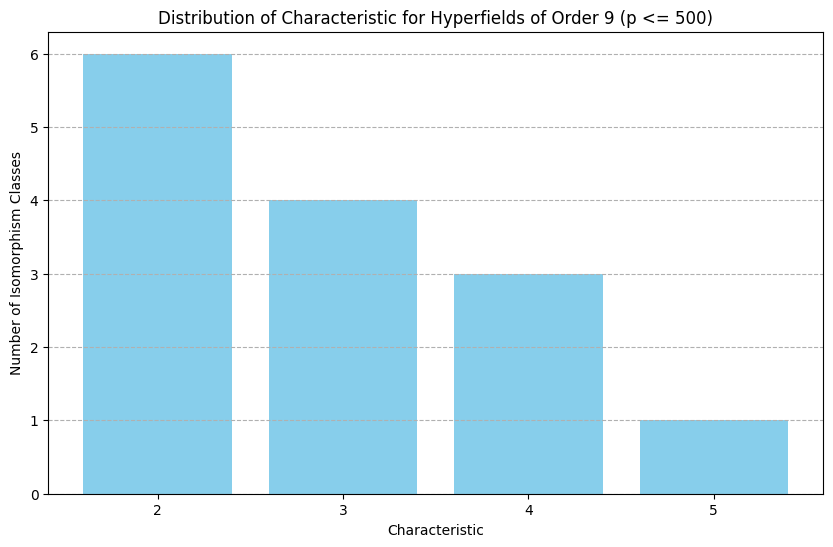

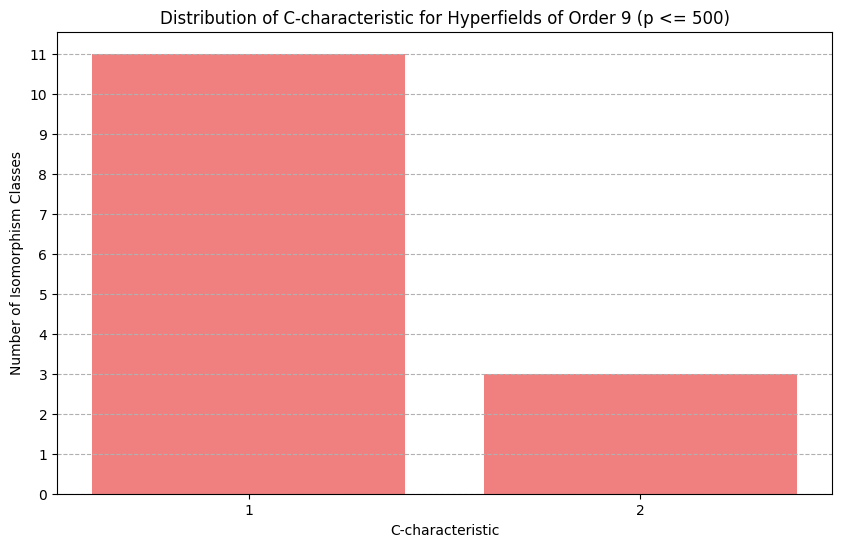

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
from sympy import primerange
import numpy as np # Import numpy for linspace

# Reuse functions from the first cell

def is_prime(n):
    if n < 2:
        return False
    if n == 2:
        return True
    if n % 2 == 0:
        return False
    r = int(n**0.5)
    for i in range(3, r+1, 2):
        if n % i == 0:
            return False
    return True

def find_primitive_root(p):
    # Finds a primitive root modulo p (generator of the multiplicative group)
    # Works only for prime p
    if p == 2:
        return 1
    phi = p - 1
    factors = prime_factors(phi)
    for g in range(2, p):
        if all(pow(g, phi // f, p) != 1 for f in factors):
            return g
    raise ValueError("No primitive root found (should not happen for prime p)")

def prime_factors(n):
    # Returns a list of prime factors of n (without multiplicity)
    factors = []
    d = 2
    while d * d <= n:
        if n % d == 0:
            factors.append(d)
            while n % d == 0:
                n //= d
        d += 1 if d == 2 else 2
    if n > 1:
        factors.append(n)
    return factors

def construct_subgroup(p, d, g):
    # Constructs the subgroup G of order d generated by g^{(p-1)/d} mod p
    step = (p - 1) // d
    # h = pow(g, step, p) # This line is not needed
    subgroup = set(pow(g, step * i, p) for i in range(d)) # Corrected power calculation
    return subgroup

def coset_representatives(p, G, g):
    # Determine coset representatives for (Z/pZ)^*/G
    seen = set()
    reps = []
    for i in range(1, p):
        if i in seen:
            continue
        coset = {(i * x) % p for x in G}
        if not any(x in seen for x in coset):
            reps.append(i)
            seen |= coset
    return reps

def element_to_coset_idx(x, G, reps, p):
    if x == 0:
        return -1
    for idx, r in enumerate(reps):
        if any((r * g) % p == x for g in G):
            return idx
    raise ValueError(f"Element {x} not found in any coset")

def hyperaddition(p, G, reps, i, j):
    # Hyperaddition of cosets reps[i], reps[j]
    A = {(reps[i] * g) % p for g in G}
    B = {(reps[j] * g) % p for g in G}
    zero = 0
    result = set()
    for a in A:
        for b in B:
            s = (a + b) % p
            if s == zero:
                result.add(-1)
            else:
                result.add(element_to_coset_idx(s, G, reps, p))
    return result

def hyper_sum_of_ones(p, G, reps, n_terms):
    # Compute 1⊞1⊞...⊞1 (n_terms)
    idx_1 = element_to_coset_idx(1, G, reps, p)
    # Need to build the table with original indices for calculation
    m = len(reps)
    table = [[set() for _ in range(m + 1)] for _ in range(m + 1)]
    for i in range(m + 1):
        table[0][i] = {i - 1} if i > 0 else {-1}
        table[i][0] = {i - 1} if i > 0 else {-1}
    for i in range(m):
        for j in range(m):
            table[i + 1][j + 1] = hyperaddition(p, G, reps, i, j)

    S = {idx_1}
    for _ in range(n_terms - 1):
        T = set()
        for a in S:
            row = a + 1 if a >= 0 else 0
            col = idx_1 + 1
            T |= table[row][col]
        S = T
    return S

def characteristic(p, G, reps, max_terms=2000):
    for n in range(1, max_terms + 1):
        if -1 in hyper_sum_of_ones(p, G, reps, n):
            return n
    return 0

def c_characteristic(p, G, reps, max_terms=2000):
    idx_1 = element_to_coset_idx(1, G, reps, p)
    for n in range(1, max_terms + 1):
        if idx_1 in hyper_sum_of_ones(p, G, reps, n + 1):
            return n
    return 0

# Reuse function from the second cell

def find_prime_divisor_pairs(n, max_p):
    from sympy import primerange

    result = []
    # Iterate over primes less than or equal to max_p
    for p in primerange(2, max_p + 1):
        val = p - 1
        # Check if (p-1) is divisible by (n-1)
        if n == 1:
            # n = 1 case does not produce valid primes under the condition
            continue
        if (val % (n - 1)) == 0:
            d = val // (n - 1)
            # Verify n = (p-1)/d + 1
            if (val // d) + 1 == n:
                result.append((p, d))
    return result

# Reuse function from the third cell
def check_isomorphism_via_add_table(p1, d1, p2, d2):
    # Check divisor conditions and primality
    if not is_prime(p1) or not is_prime(p2):
        return "Error: p1 and p2 must be prime numbers."
    if d1 <= 0 or (p1 - 1) % d1 != 0 or d2 <= 0 or (p2 - 1) % d2 != 0:
        return "Error: d1 must be a positive divisor of p1-1 and d2 must be a positive divisor of p2-1."

    # Construct hyperfields for both pairs
    try:
        g1 = find_primitive_root(p1)
        G1 = construct_subgroup(p1, d1, g1)
        reps1 = coset_representatives(p1, G1, g1)
        m1 = len(reps1)

        g2 = find_primitive_root(p2)
        G2 = construct_subgroup(p2, d2, g2)
        reps2 = coset_representatives(p2, G2, g2)
        m2 = len(reps2)
    except ValueError as e:
         return f"Error during hyperfield construction: {e}"


    # Check if the number of non-zero elements is the same
    if m1 != m2:
        return "The generated hyperfields are not isomorphic (different cardinalities of non-zero elements)."

    # Build addition tables using indices (-1 for 0, 0..m-1 for reps)
    table1_indices = [[set() for _ in range(m1 + 1)] for _ in range(m1 + 1)]
    for i in range(m1 + 1):
        table1_indices[0][i] = {i - 1} if i > 0 else {-1}
        table1_indices[i][0] = {i - 1} if i > 0 else {-1}
    for i in range(m1):
        for j in range(m1):
            table1_indices[i + 1][j + 1] = hyperaddition(p1, G1, reps1, i, j)

    table2_indices = [[set() for _ in range(m2 + 1)] for _ in range(m2 + 1)]
    for i in range(m2 + 1):
        table2_indices[0][i] = {i - 1} if i > 0 else {-1}
        table2_indices[i][0] = {i - 1} if i > 0 else {-1}
    for i in range(m2):
        for j in range(m2):
            table2_indices[i + 1][j + 1] = hyperaddition(p2, G2, reps2, i, j)

    # Find the table index of [1] (coset containing 1)
    try:
        idx_1_tab1 = element_to_coset_idx(1, G1, reps1, p1) + 1
        idx_1_tab2 = element_to_coset_idx(1, G2, reps2, p2) + 1
    except ValueError:
         return "Error: Could not find element [1] in cosets."


    # --- New check based on inverse of [1] ---
    # Find the table index of the element that is the inverse of [1]
    inv_1_tab_idx1 = -1 # Initialize with a value outside valid table indices
    for j in range(m1 + 1):
        if -1 in table1_indices[idx_1_tab1][j]: # Check if [0] is in [1] + element_at_j
            inv_1_tab_idx1 = j
            break

    inv_1_tab_idx2 = -1
    for j in range(m2 + 1):
        if -1 in table2_indices[idx_1_tab2][j]: # Check if [0] is in [1] + element_at_j
            inv_1_tab_idx2 = j
            break

    # If no inverse found (shouldn't happen in these structures for [1]), return error
    if inv_1_tab_idx1 == -1 or inv_1_tab_idx2 == -1:
         return "Error: Could not find the inverse of [1] in one or both hyperfields."

    # Compare the table indices of the inverses of [1].
    # If they are different, the hyperfields are not isomorphic under an iso fixing [1].
    if inv_1_tab_idx1 != inv_1_tab_idx2:
        # Determine which element is the inverse based on table index
        inv_1_elem1 = 0 if inv_1_tab_idx1 == 0 else reps1[inv_1_tab_idx1 - 1]
        inv_1_elem2 = 0 if inv_1_tab_idx2 == 0 else reps2[inv_1_tab_idx2 - 1]
        return f"The generated hyperfields are not isomorphic."


    # --- Proceed with multiset comparison if inverse position is the same ---
    # Collect the multisets of {1} + {a} for both hyperfields
    multiset1 = []
    for i in range(m1 + 1): # Iterate through all elements (including zero)
         # Get the set from the table and convert it to a frozenset for hashing
         multiset1.append(frozenset(table1_indices[idx_1_tab1][i]))

    multiset2 = []
    for i in range(m2 + 1): # Iterate through all elements (including zero)
         # Get the set from the table and convert it to a frozenset for hashing
         multiset2.append(frozenset(table2_indices[idx_1_tab2][i]))

    # Compare the multisets
    # Convert lists to sorted lists of frozensets to compare multisets
    multiset1.sort()
    multiset2.sort()

    if multiset1 == multiset2:
        return "The generated hyperfields are isomorphic."
    else:
        return "The generated hyperfields are not isomorphic (multisets of [1]+[a] sums differ)."


def main_visualization():
    while True:
        try:
            n = int(input("Enter the desired hyperfield order (n): "))
            if n <= 0:
                print("n must be a positive integer. Try again.")
                continue
            max_p = int(input("Enter the maximum prime to consider (max_p): "))
            if max_p <= 1:
                print("max_p must be greater than 1. Try again.")
                continue
            break
        except ValueError:
            print("Invalid input. Please enter integer values.")

    pairs = find_prime_divisor_pairs(n, max_p)
    print(f"Found {len(pairs)} pairs (p, d) for hyperfield order n={n} with p <= {max_p}.")

    isomorphism_classes = []
    processed_pairs = set()

    print("Checking for isomorphism classes...")
    for i in range(len(pairs)):
        p1, d1 = pairs[i]
        if (p1, d1) in processed_pairs:
            continue

        current_class = [(p1, d1)]
        processed_pairs.add((p1, d1))

        for j in range(i + 1, len(pairs)):
            p2, d2 = pairs[j]
            if (p2, d2) in processed_pairs:
                continue

            # Check for isomorphism
            isomorphic_result = check_isomorphism_via_add_table(p1, d1, p2, d2)

            print(f"Checking isomorphism for ({p1}, {d1}) and ({p2}, {d2}): {isomorphic_result}")

            if isomorphic_result == "The generated hyperfields are isomorphic.":
                current_class.append((p2, d2))
                processed_pairs.add((p2, d2))
            elif "Error" in isomorphic_result:
                print(f"Skipping isomorphism check for ({p1}, {d1}) and ({p2}, {d2}) due to error: {isomorphic_result}")


        isomorphism_classes.append(current_class)

    print(f"Found {len(isomorphism_classes)} isomorphism classes.")

    char_counts = defaultdict(int)
    cchar_counts = defaultdict(int)

    print("Computing characteristics for each isomorphism class...")
    for iso_class in isomorphism_classes:
        # Take the first pair from the class to compute characteristics
        p, d = iso_class[0]
        try:
            g = find_primitive_root(p)
            G = construct_subgroup(p, d, g)
            reps = coset_representatives(p, G, g)

            char = characteristic(p, G, reps)
            cchar = c_characteristic(p, G, reps)

            char_counts[char] += 1
            cchar_counts[cchar] += 1
            print(f"Class starting with ({p}, {d}): Char = {char}, C-Char = {cchar}")

        except ValueError as e:
            print(f"Error computing characteristics for ({p}, {d}): {e}")


    # Plotting characteristic distribution
    chars = sorted(char_counts.keys())
    counts = [char_counts[c] for c in chars]

    plt.figure(figsize=(10, 6))
    plt.bar(chars, counts, color='skyblue')
    plt.xlabel("Characteristic")
    plt.ylabel("Number of Isomorphism Classes")
    plt.title(f"Distribution of Characteristic for Hyperfields of Order {n} (p <= {max_p})")
    # Set x-axis ticks to show all integers from min_char to max_char
    min_char = min(chars) if chars else 2
    max_char = max(chars) if chars else 2
    plt.xticks(np.arange(min_char, max_char + 1, 1))
    # Set y-axis ticks to show only integers
    max_count = max(counts) if counts else 1
    plt.yticks(np.arange(0, max_count + 1, 1))
    plt.grid(axis='y', linestyle='--')
    plt.show()

    # Plotting c-characteristic distribution
    cchars = sorted(cchar_counts.keys())
    ccounts = [cchar_counts[cc] for cc in cchars]

    plt.figure(figsize=(10, 6))
    plt.bar(cchars, ccounts, color='lightcoral')
    plt.xlabel("C-characteristic")
    plt.ylabel("Number of Isomorphism Classes")
    plt.title(f"Distribution of C-characteristic for Hyperfields of Order {n} (p <= {max_p})")
    # Set x-axis ticks to show all integers from 1 to max_cchar
    min_cchar = min(cchars) if cchars else 1
    max_cchar = max(cchars) if cchars else 1
    plt.xticks(np.arange(min_cchar, max_cchar + 1, 1))
    # Set y-axis ticks to show only integers
    max_ccount = max(ccounts) if ccounts else 1
    plt.yticks(np.arange(0, max_ccount + 1, 1))
    plt.grid(axis='y', linestyle='--')
    plt.show()


if __name__ == "__main__":
    main_visualization()